# 1D CNN

Сегодня мы познакомимся со сверточными нейронными сетями для последовательностей. CNN, как правило, состоят из двух ключевых слоев: 
1) Convolution
2) Pooling

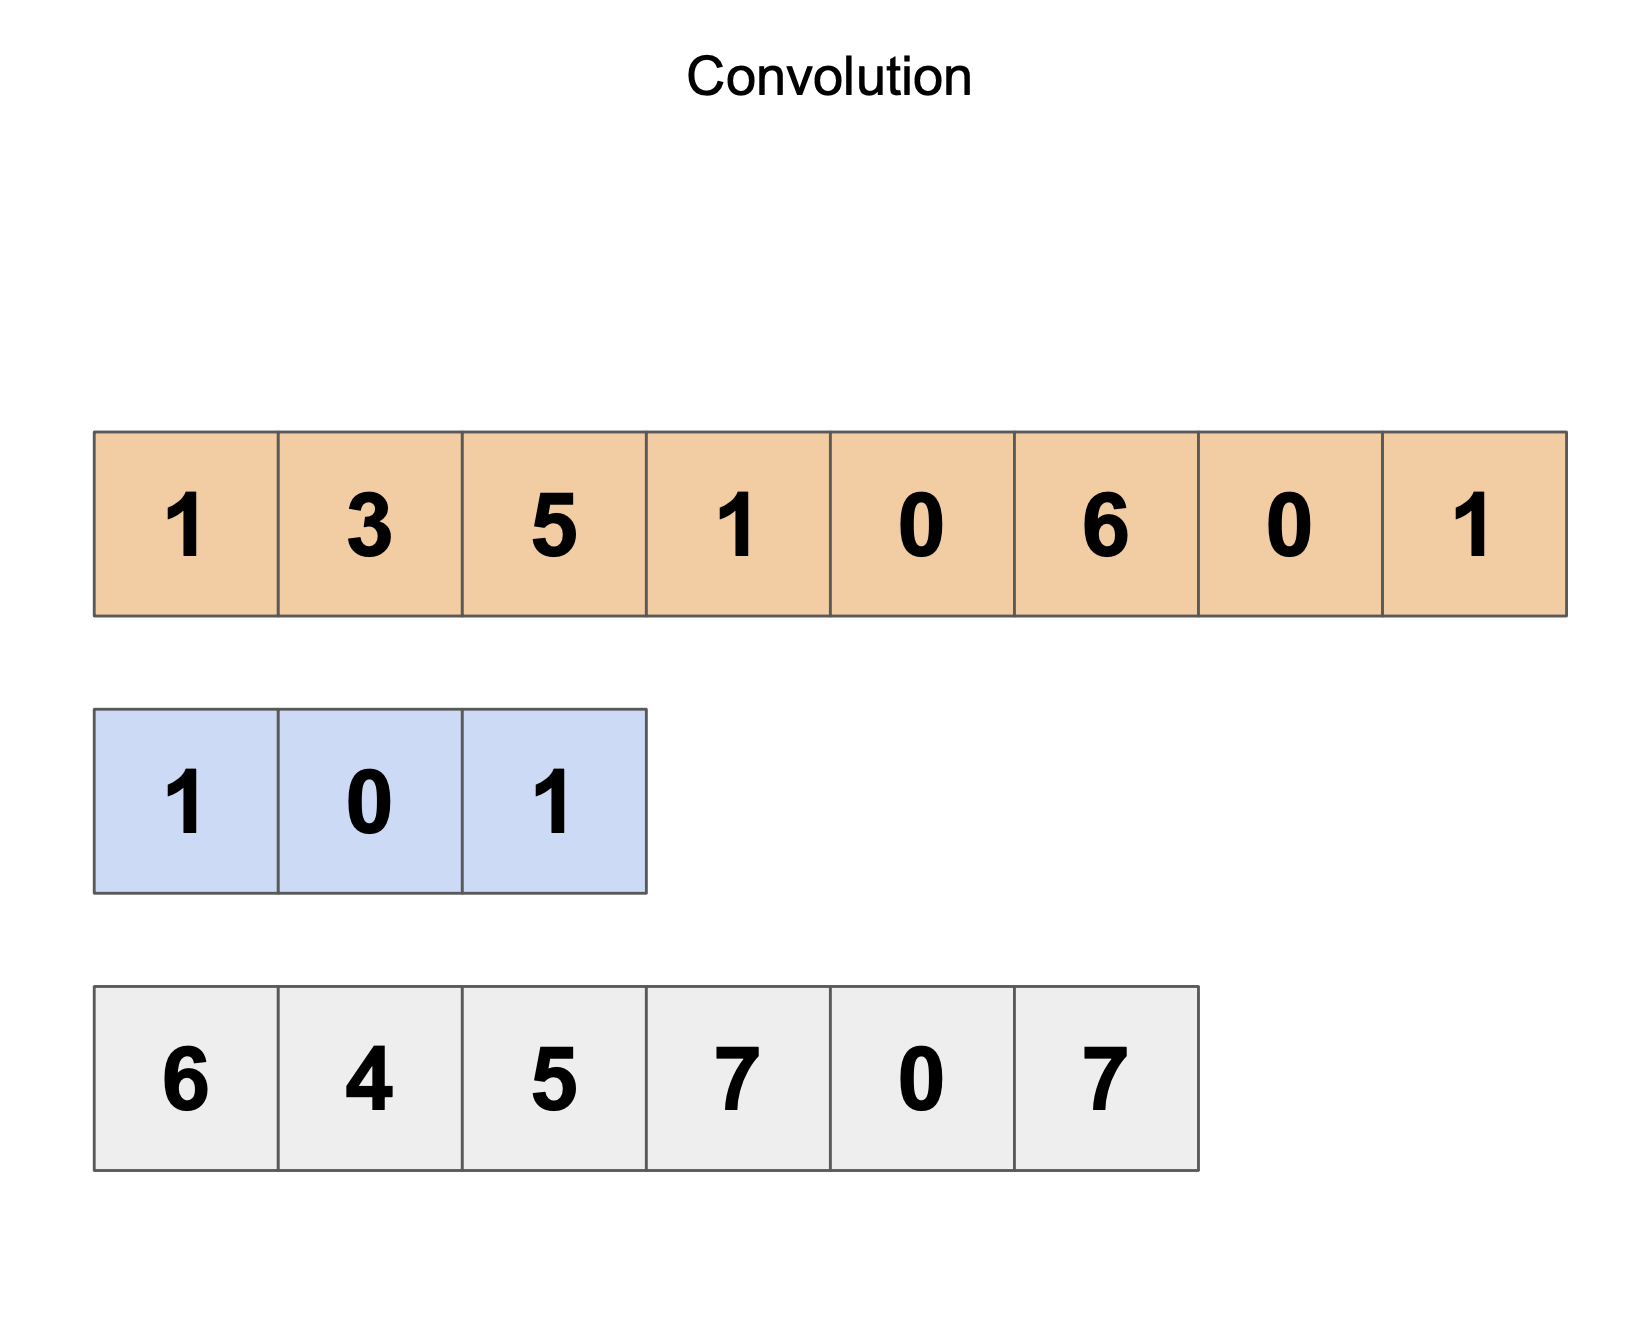


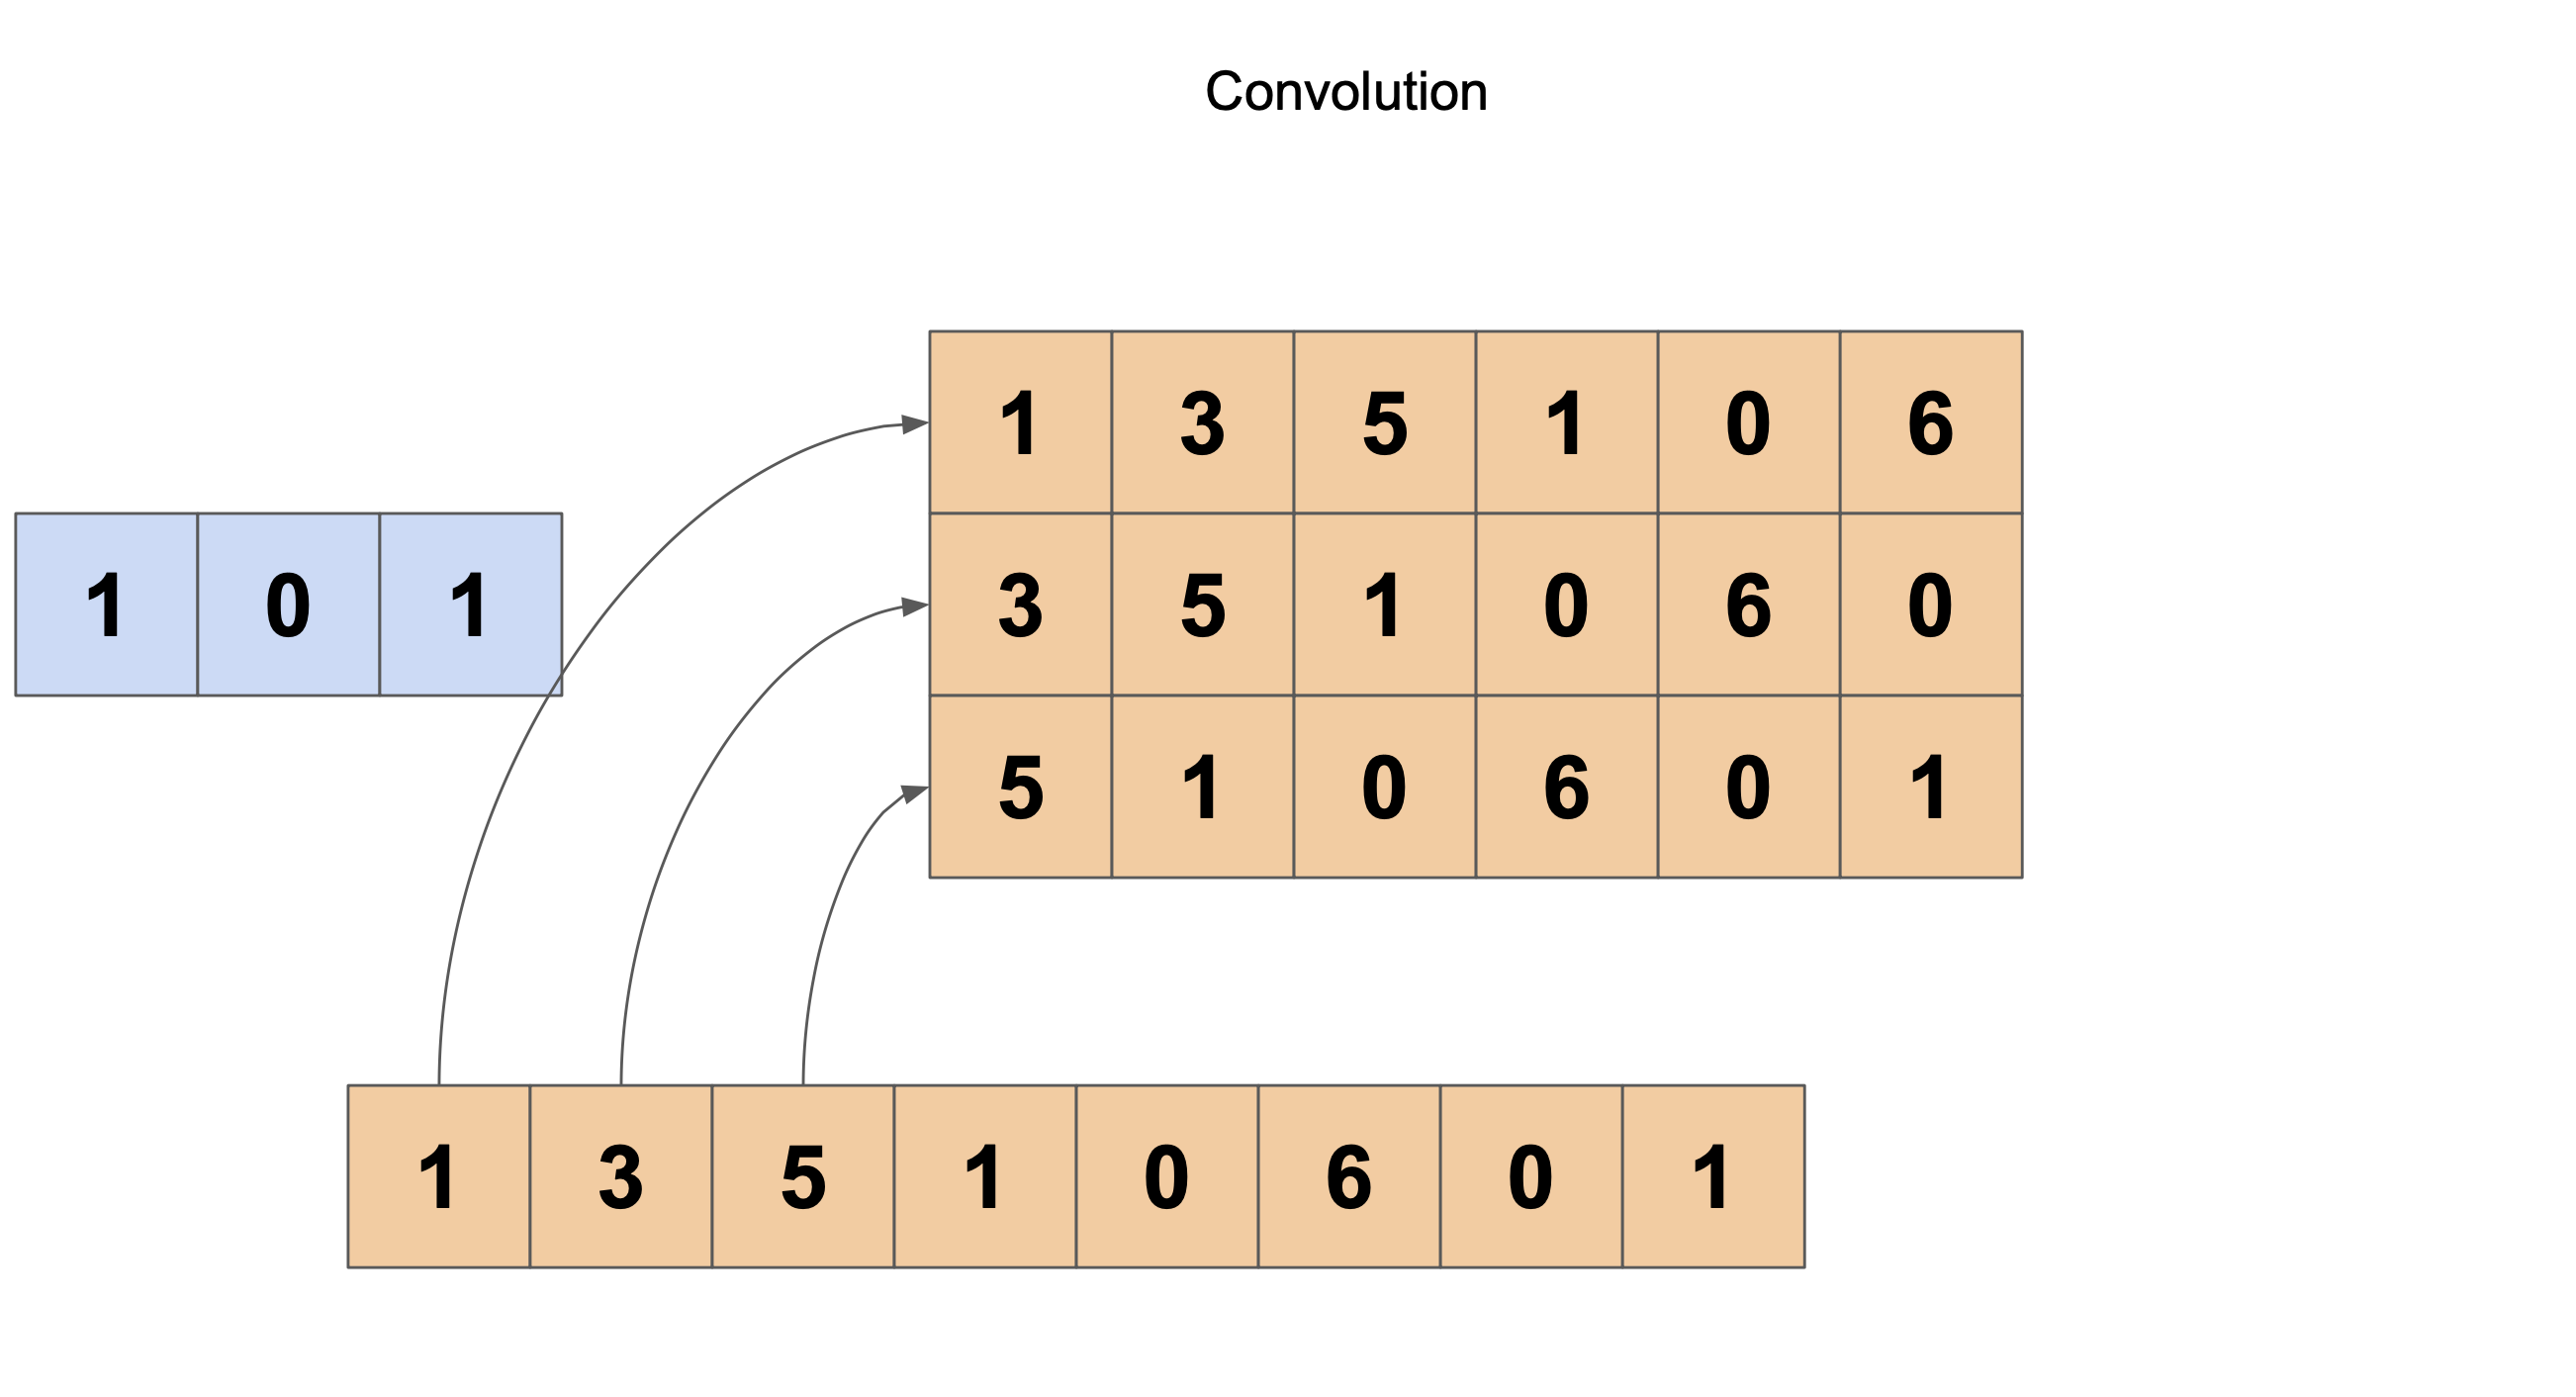

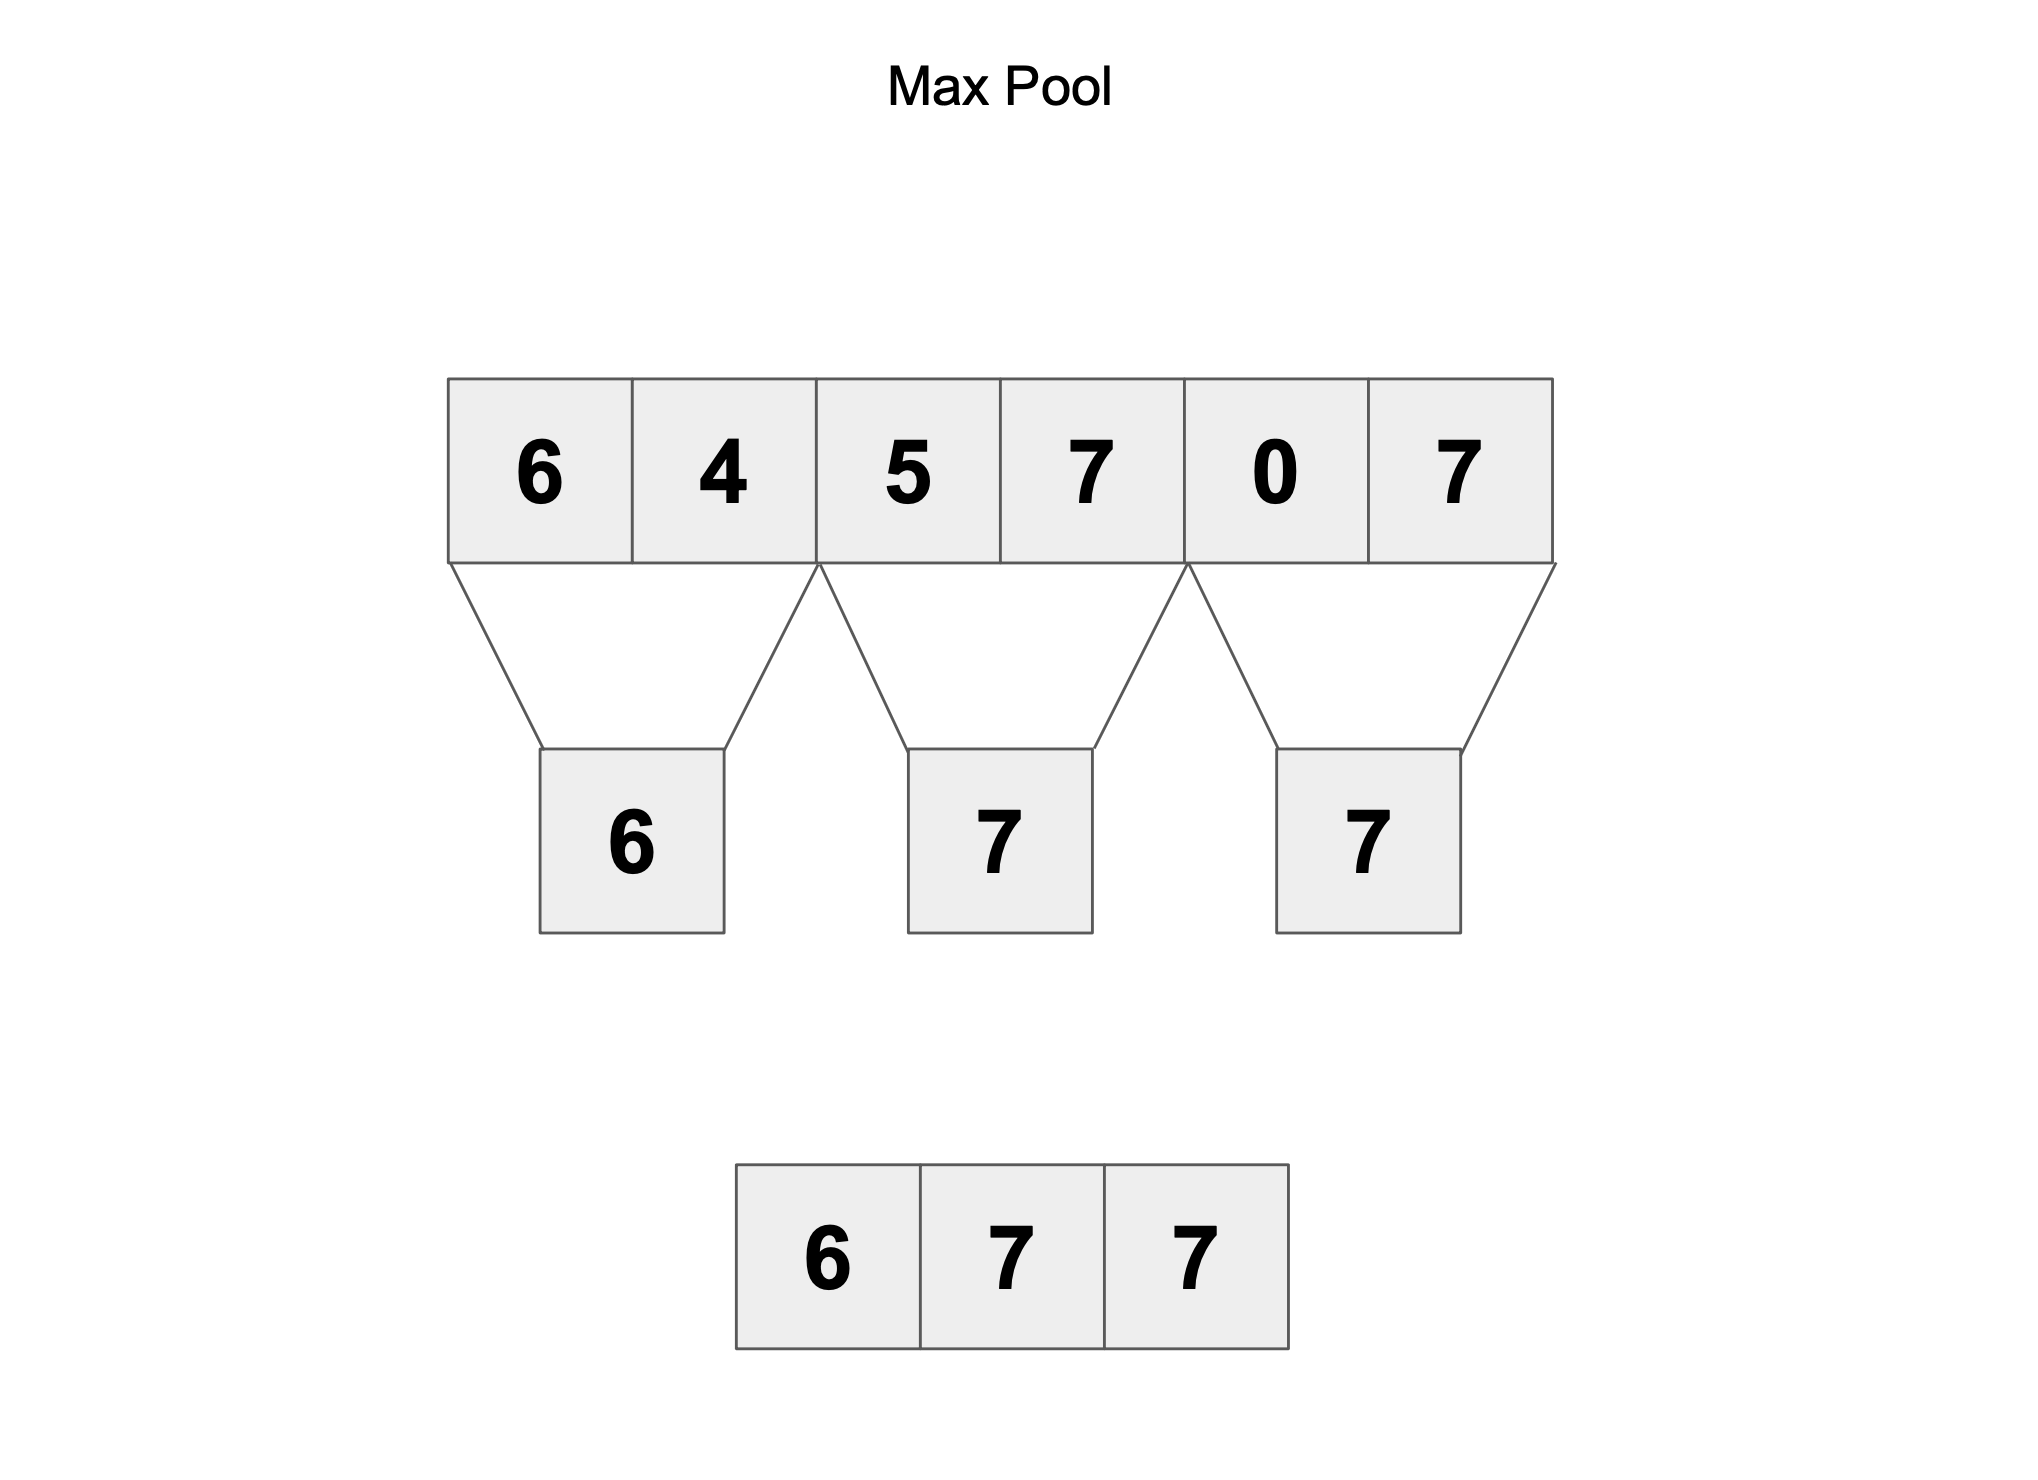

Теперь, когда сы разобрались с тем, как это работает, давайте решим конкретную задачу с помощью 1d CNN

Мы будем решать задачу распознования разных активностей человека. Данные представляют из себя запись с акселерометра и гироскопа с обычного смартфона  Samsung Galaxy S II. Все данные записаны два раза, в 1 слуае, человек держит телефон в левой руке, во второй раз в правой. В наборе данных есть 6 разных активностей, которые делают люди:
1) Ходьба
2) Ходьба по лестнице вниз
3) Ходьба по лестнице вверх
4) Человек сидит
5) Человек стоит
6) Человек лежит


In [ ]:
import tensorflow
tensorflow.__version__

AttributeError: ignored

In [ ]:
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, MaxPooling1D, AveragePooling1D, Flatten, Conv1D, ReLU
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

KeyboardInterrupt: ignored

The load_dataset_group() function below loads all input signal data and the output data for a single group using the consistent naming conventions between the train and test directories.

In [ ]:
def load_group(filenames, prefix=''):
	loaded = []
	for name in filenames:
		data = pd.read_csv(prefix + name, header=None, delim_whitespace=True).values
		loaded.append(data)
	loaded = np.dstack(loaded)
	return loaded

def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	X = load_group(filenames, filepath)
	y = pd.read_csv(prefix + group + '/y_'+group+'.txt', header=None, delim_whitespace=True).values
	return X, y

In [ ]:
!wget --no-check-certificate https://www.dropbox.com/s/ufxcrvolaaima6g/UCI%20HAR%20Dataset.zip #?dl=0 -O UCI HAR Dataset.zip

--2022-06-08 14:37:01--  https://www.dropbox.com/s/ufxcrvolaaima6g/UCI%20HAR%20Dataset.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ufxcrvolaaima6g/UCI%20HAR%20Dataset.zip [following]
--2022-06-08 14:37:01--  https://www.dropbox.com/s/raw/ufxcrvolaaima6g/UCI%20HAR%20Dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbcf8a47d046cf74701632291a6.dl.dropboxusercontent.com/cd/0/inline/Bm1hifOjKQQXSNIX_e5s7_brZgvFIhmJJy_RXxnn0ubffAJIyNNwwtrH3-kuVe45Pbg8zjoq-O5HioOX6kY1egNoiDK7aw1dgV09wWyaOEf5zceRPBnY-eudVf9yuwtcgCV0QwSY43tAyGRWDja1zkUIi7nfL71lKOg23wRFctNYaw/file# [following]
--2022-06-08 14:37:02--  https://ucbcf8a47d046cf74701632291a6.dl.dropboxusercontent.com/cd/0/inline/Bm1hifOjKQQXSNIX_e5s7_brZgvFIhmJJy_

In [ ]:
from zipfile import ZipFile
with ZipFile('UCI HAR Dataset.zip', 'r') as zipObj:
    # Extract all the contents of zip file in current directory
    zipObj.extractall()

In [ ]:
train_X, train_y = load_dataset_group('train', 'UCI HAR Dataset/')
test_X, test_y = load_dataset_group('test', 'UCI HAR Dataset/')

train_y -= 1
test_y -= 1

train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


In [ ]:
max_timesteps, num_features, num_outputs = train_X.shape[1], train_X.shape[2], train_y.shape[1]

def make_model(cnn_blocks, max_timesteps=max_timesteps, num_features=num_features, num_outputs=num_outputs, lr=1e-3):
    model = Sequential()
    
    block = cnn_blocks[0]

    model.add(Conv1D(filters=block['filters'], kernel_size=block['kernel_size'], input_shape=(max_timesteps, num_features)))
    model.add(block['pool'][0](pool_size=block['pool'][1]))
    
    for block in cnn_blocks[1:]:
        model.add(Conv1D(filters=block['filters'], kernel_size=block['kernel_size']))
        model.add(block['pool'][0](pool_size=block['pool'][1]))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
    return model


cnn_blocks = [
    {
        'filters': 64,
        'kernel_size': 3,
        'pool': (MaxPooling1D, 2),
    },
]
model = make_model(cnn_blocks)
history = model.fit(train_X, train_y, epochs=12, batch_size=16)

Epoch 1/12
460/460 [==============================] - 4s 7ms/step - loss: 0.4320 - accuracy: 0.8383
Epoch 2/12
460/460 [==============================] - 4s 8ms/step - loss: 0.2028 - accuracy: 0.9263
Epoch 3/12
460/460 [==============================] - 4s 8ms/step - loss: 0.1397 - accuracy: 0.9433
Epoch 4/12
460/460 [==============================] - 5s 12ms/step - loss: 0.1193 - accuracy: 0.9508
Epoch 5/12
460/460 [==============================] - 5s 12ms/step - loss: 0.1051 - accuracy: 0.9565
Epoch 6/12
460/460 [==============================] - 5s 11ms/step - loss: 0.1211 - accuracy: 0.9487
Epoch 7/12
460/460 [==============================] - 4s 9ms/step - loss: 0.1272 - accuracy: 0.9480
Epoch 8/12
460/460 [==============================] - 3s 7ms/step - loss: 0.1089 - accuracy: 0.9525
Epoch 9/12
460/460 [==============================] - 3s 7ms/step - loss: 0.1058 - accuracy: 0.9563
Epoch 10/12
460/460 [==============================] - 3s 7ms/step - loss: 0.0859 - accuracy: 0.9

In [ ]:
_, accuracy = model.evaluate(test_X, test_y, batch_size=16, verbose=0)
print('TEST ACCURACY: ', accuracy)

TEST ACCURACY:  0.9121140241622925


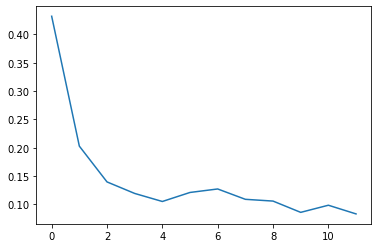

In [ ]:
plt.plot(history.history['loss'])

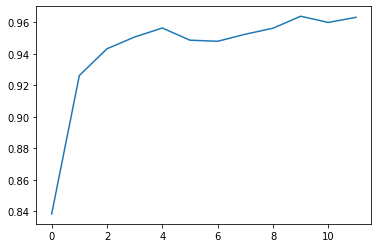

In [ ]:
plt.plot(history.history['accuracy'])

In [ ]:
cnn_blocks = [
    {
        'filters': 64,
        'kernel_size': 3,
        'pool': (AveragePooling1D, 2),
    },
]

model = make_model(cnn_blocks)
history = model.fit(train_X, train_y, epochs=12, batch_size=16)

_, accuracy = model.evaluate(test_X, test_y, batch_size=16, verbose=0)
print('TEST ACCURACY: ', accuracy)

Epoch 1/12
460/460 [==============================] - 4s 7ms/step - loss: 0.5344 - accuracy: 0.8067
Epoch 2/12
460/460 [==============================] - 3s 7ms/step - loss: 0.2342 - accuracy: 0.9127
Epoch 3/12
460/460 [==============================] - 3s 7ms/step - loss: 0.1674 - accuracy: 0.9335
Epoch 4/12
460/460 [==============================] - 3s 7ms/step - loss: 0.1425 - accuracy: 0.9414
Epoch 5/12
460/460 [==============================] - 3s 7ms/step - loss: 0.1225 - accuracy: 0.9505
Epoch 6/12
460/460 [==============================] - 3s 7ms/step - loss: 0.1135 - accuracy: 0.9536
Epoch 7/12
460/460 [==============================] - 3s 7ms/step - loss: 0.1102 - accuracy: 0.9510
Epoch 8/12
460/460 [==============================] - 3s 7ms/step - loss: 0.1089 - accuracy: 0.9525
Epoch 9/12
460/460 [==============================] - 3s 7ms/step - loss: 0.0949 - accuracy: 0.9587
Epoch 10/12
460/460 [==============================] - 3s 7ms/step - loss: 0.0936 - accuracy: 0.9610

In [ ]:
cnn_blocks = [
    {
        'filters': 64,
        'kernel_size': 3,
        'pool': (MaxPooling1D, 2),
    },
    {
        'filters': 64,
        'kernel_size': 5,
        'pool': (MaxPooling1D, 2),
    },
]

model = make_model(cnn_blocks, lr=1e-4)
history = model.fit(train_X, train_y, epochs=18, batch_size=16)

_, accuracy = model.evaluate(test_X, test_y, batch_size=16, verbose=0)
print('TEST ACCURACY: ', accuracy)

Epoch 1/18
460/460 [==============================] - 6s 12ms/step - loss: 0.7531 - accuracy: 0.7129
Epoch 2/18
460/460 [==============================] - 6s 13ms/step - loss: 0.4205 - accuracy: 0.8400
Epoch 3/18
460/460 [==============================] - 5s 11ms/step - loss: 0.2978 - accuracy: 0.8989
Epoch 4/18
460/460 [==============================] - 5s 11ms/step - loss: 0.2259 - accuracy: 0.9189
Epoch 5/18
460/460 [==============================] - 5s 11ms/step - loss: 0.1868 - accuracy: 0.9321
Epoch 6/18
460/460 [==============================] - 5s 11ms/step - loss: 0.1620 - accuracy: 0.9392
Epoch 7/18
460/460 [==============================] - 5s 11ms/step - loss: 0.1455 - accuracy: 0.9450
Epoch 8/18
460/460 [==============================] - 5s 11ms/step - loss: 0.1345 - accuracy: 0.9478
Epoch 9/18
460/460 [==============================] - 5s 12ms/step - loss: 0.1251 - accuracy: 0.9491
Epoch 10/18
460/460 [==============================] - 5s 11ms/step - loss: 0.1193 - accura

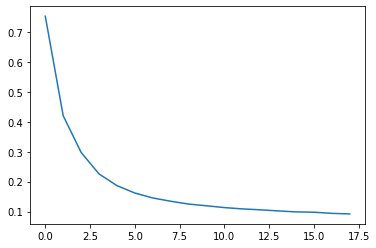

In [ ]:
plt.plot(history.history['loss'])